In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from tensorflow.keras.layers import LeakyReLU

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
from stellargraph import datasets
dataset = datasets.PubMedDiabetes()
G, target = dataset.load()
nodes = list(G.nodes())
features = pd.DataFrame(G.node_features(nodes), index=nodes)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]


In [3]:
tr_target, val_target = model_selection.train_test_split(
    target, train_size=0.2, stratify=target
)

val_target, test_target = model_selection.train_test_split(
    val_target, train_size=0.5, stratify=val_target
)

In [4]:
lbe = preprocessing.LabelBinarizer()

tr_target = pd.DataFrame(lbe.fit_transform(tr_target.values), index=tr_target.index)
val_target = pd.DataFrame(lbe.fit_transform(val_target.values), index=val_target.index)
test_target = pd.DataFrame(lbe.fit_transform(test_target.values), index=test_target.index)
tot_target = pd.DataFrame(lbe.fit_transform(target.values), index=target.index)

In [5]:
from stellargraph.mapper import ClusterNodeGenerator

generator = ClusterNodeGenerator(G, clusters=10, q=10, name='generator') # q: clusters per batch


Number of clusters 10
0 cluster has size 1971
1 cluster has size 1971
2 cluster has size 1971
3 cluster has size 1971
4 cluster has size 1971
5 cluster has size 1971
6 cluster has size 1971
7 cluster has size 1971
8 cluster has size 1971
9 cluster has size 1978


In [6]:
tr_flow = generator.flow(tr_target.index, tr_target, name='train') # node_id, target
val_flow = generator.flow(val_target.index, val_target, name='val')
test_flow = generator.flow(test_target.index, test_target, name='test')
tot_flow = generator.flow(tot_target.index, tot_target, name='tot')

In [7]:
from stellargraph.layer import ClusterGCN
import tensorflow.keras.backend as K
# like keras models
gcn = ClusterGCN(layer_sizes=[1024, 512], activations=['elu', 'elu'], generator=generator, dropout=0.5, bias=True)

# build network
nc_inp, nc_out = gcn.build()

nc_layer = layers.Dense(128, activation='relu')(nc_out)
nc_layer = layers.Dense(tr_target.shape[1], activation='softmax')(nc_layer)

nc_model = Model(inputs=nc_inp, outputs=nc_layer)
nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)


pred_layer = layers.Lambda(lambda x: K.squeeze(x, 0))(nc_layer)
pred_model = Model(nc_inp, pred_layer)

In [8]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_acc')
nc_hist = nc_model.fit(tr_flow, epochs=200,
                validation_data=val_flow,
                shuffle=False, # should be False!!
                callbacks=[es],
                verbose=0)  

  ...
    to  
  ['...']
  ...
    to  
  ['...']


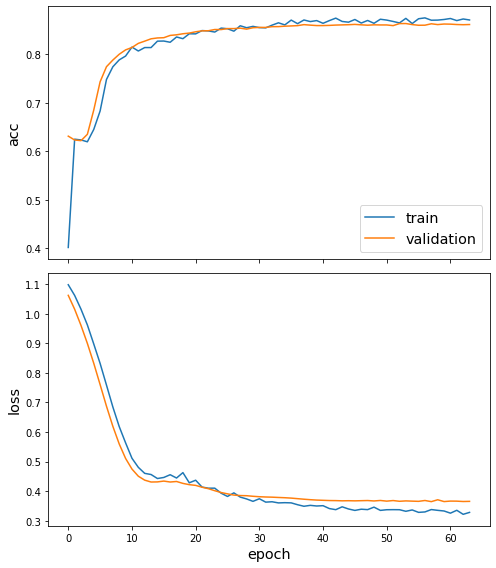

In [9]:
sg.utils.plot_history(nc_hist)

In [10]:
from sklearn.metrics import f1_score

res = list(map(np.argmax, pred_model.predict(test_flow)))
test_label = list(map(np.argmax, test_target.loc[test_flow.node_order].values))

f1_micro = f1_score(test_label, res, average='micro')
f1_marco = f1_score(test_label, res, average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.864 
f1_macro: 0.86


In [11]:
from sklearn.linear_model import LogisticRegression

tr_tar = list(map(lambda x: np.argmax(x), tr_target.values))
lr = LogisticRegression().fit(features.loc[tr_target.index], tr_tar)

f1_micro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='micro')
f1_macro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.839 
f1_macro: 0.86
